# Практическое задание к уроку 4. Семантическая сегментация


Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import os
import sys
import skimage.io as io
import numpy as np

import tensorflow as tf
import random
import imageio

import matplotlib.pyplot as plt

%matplotlib inline

from skimage.transform import resize
from tensorflow.keras import layers

# gpu_device = tf.config.experimental.list_physical_devices('GPU')
# if gpu_device:
#     tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [3]:
tf.__version__

'2.8.2'

## Загрузка датасета COCO и COCO API

In [4]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    # Архив с анотациями (разметкой)
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    # Библиотека для работы с натациями датасета COCO
    !cd data && git clone https://github.com/cocodataset/cocoapi
    # Собираем и подготавливаем библиотеку к работе
    !cd data/cocoapi/PythonAPI && make

--2022-08-09 09:11:32--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.165.57
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.165.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  45.7MB/s    in 6m 47s  

2022-08-09 09:18:20 (45.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-08-09 09:18:20--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.68.196
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.68.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  40.0MB/s    in 60s     

2022-08-09 09:19:20 (12.9 MB/s) - ‘v

In [5]:
# !rm -rf data/train2017
# !rm /data/train2017.zip
# !du ./data/train2017
# !du ./data/

#### Загрузка датасета COCO и COCO API
В Kaggle подключаем датасет через интерфейс: https://www.kaggle.com/awsaf49/coco-2017-dataset

##### Установка COCO API

In [6]:
# !pwd

In [7]:
# os.listdir('..')

In [8]:
# склонируем библиотеку для работы с COCO API
# !git clone https://github.com/cocodataset/cocoapi
# !cd cocoapi/PythonAPI && make

## Подготовка COCO API

In [9]:
# Импортируем библиотеку для чтения нотации и работы с ней
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

# COCO_ROOT = '../input/coco-2017-dataset/coco2017/'
# import sys
# sys.path.insert(0, os.path.join('', 'cocoapi/PythonAPI'))
# from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [10]:
# Подготавливаем pipeline данных для сегментации
class Dataset():
    
    # Создание универсального класса для произвольной сегментации
    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):
        
        # картинки разного размера. Чтобы привести их к одному размеру будем делать кроп
        # кроп будем производить случайным образом, получится аугументация, что хорошо
        def item_to_images(item):
            # Чтение картинки с диска
            # item - указание на то, где находится картинка
            random_crop = True
            # Для чтения используется ф-я read_images,
            # которая д.б. реализована в дочернем классе
            # img_combined - выход, комбинированная картинка,
            # где по канальному измерению сконкатенирована наша исходная картинка rgb
            # и картинка с метками класса. Все картинки имеют тип int8.
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            # Вызываем кроп для неё (см. выше ф-ю crop_images)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            # Исходная картинка
            # предполагаем, что она находится в первых 3-х каналах
            # Мы считаем, что функция read_images нам возвращает
            # в первых 3-х каналах картинку,
            # а в последнем карту сегментации
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            # Карта сегментации (находится в последнем канале)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class # картинка и маска

        # img_list - список путей к файлам с картинками
        # Из этого списка путей к картинкам создаём датасет
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        # Перемешиваем его
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        # Для каждого элемента датасета применяем функцию item_to_images
        # подлучаем картинку и её маску
        dataset = dataset.map(item_to_images) # датасет с картинками
        dataset = dataset.repeat(epochs) # повтор по количеству эпох
        dataset = dataset.batch(batch_size, drop_remainder=True) # пакет

        return dataset # возвращает датасет для дальнейшей работы

    def val_dataset(self, batch_size, inp_size):

        # Создание валидационного датасета
        # Для объединения картинок в batch они д.б. одного размера
        # Для валидации делаем центральный crop
        def item_to_images(item):
            # То же самое, что и для train
            # Только random_crop = False и нет повтора по эпохам
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [11]:
class COCO_Dataset(Dataset):

    # Наследуемся от универсального класса и создаём класс для датасета COCO
    # Кастомный, специальный способ загрузки изображений
    def __init__(self, sublist): # Специфичный для COCO конструктор
        # Путь к разметке
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        # Инициализируем класс COCO (используем COCO-api)
        self.coco = COCO(ann_file_fpath)
        # Указываем какие категории мы хотим использовать. 
        # Можно указать список категорий ['person', ...]
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        # Получаем картинки с категориями
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    # Ф-я по элементу списка img_list получает картинку и маски
    # У картинки м.б. несколько масок. Каждая сидит в отдельном слое.
    # Мы их все суммируем
    def read_images(self, img_id):
        # Функция чтения изображения возвращает
        # в первых 3-х каналах картинку, в последнем - карту сегментации.
        # Логика специфичная для COCO
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        # Суммируем все маски у картинки
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined # возвращается исходная картинка

In [12]:
# создаём train и валидационный датасеты
# строка train и val передаётся в COCO Dataset конструктор для чтения нужного json-файла
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [13]:
# Уменьшение количества изображений в датасете, чтобы модель обучилась за адекватное время

COCO_dataset_train.cat_ids=COCO_dataset_train.cat_ids[:700]
COCO_dataset_train.img_list=COCO_dataset_train.img_list[:700]

COCO_dataset_val.cat_ids=COCO_dataset_val.cat_ids[:100]
COCO_dataset_val.img_list=COCO_dataset_val.img_list[:100]

In [14]:
len(COCO_dataset_train.img_list), len(COCO_dataset_train.cat_ids)

(700, 1)

In [15]:

len(COCO_dataset_val.img_list), len(COCO_dataset_val.cat_ids)

(100, 1)

In [16]:
NUM_EPOCHS = 5
BATCH_SIZE = 8
inp_size = 256

In [17]:
# из COCO датасетов получаем датасеты для tensorflow
# train_dataset() missing 2 required positional arguments: 'epochs' and 'inp_size'

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,inp_size=inp_size)

val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=inp_size)


## Визуализация датасета

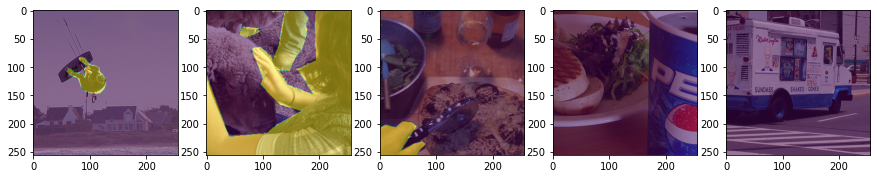

In [18]:
# Выполним визуализацию 
# %matplotlib inline
# import matplotlib.pyplot as plt

img, mask = next(iter(val_ds.take(1)))

fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask[...,0][i],alpha=0.5)
plt.show()

## Модель ASPP

In [19]:
# class ASPPBlock(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
#         self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
#         self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
#         self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

#     def call(self, inp, is_training=False):
#         out1 = self.conv1(inp)
#         out2 = self.conv2(inp)
#         out3 = self.conv3(inp)
#         out4 = self.conv4(inp)
#         out = tf.concat([out1, out2, out3, out4], axis=3)
#         out = self.conv5(out)
#         return out
    
# class ASPPNet(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

    #     self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
    #     self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
    #     self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
    #     self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

    #     self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

    #     self.aspp = ASPPBlock()

    # def call(self, x):

    #     out = self.conv1(x)
    #     out = self.conv2(out)
    #     out = self.maxpool(out)
    #     out = self.conv3(out)
    #     out = self.conv4(out)
    #     out = self.maxpool(out)
    #     out = self.conv5(out)
    #     out = self.conv6(out)
    #     out_enc_mid = out
    #     out = self.maxpool(out)
    #     out = self.conv7(out)
    #     out = self.conv8(out)
    #     out = self.maxpool(out)
    #     out = self.conv9(out)
    #     out = self.conv10(out)

    #     out = self.aspp(out)

    #     out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

    #     out_enc_mid = self.conv11(out_enc_mid)

    #     out = tf.concat([out, out_enc_mid], axis=3)

    #     out = self.conv12(out)
    #     out = self.conv13(out)
    #     out = self.conv14(out)

#         out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
#         out = tf.nn.sigmoid(out)
#         return out
    
# model = ASPPNet()

## Создание модели U-Net

In [20]:
# WEIGHT_DECAY = 0.001

# wd = tf.keras.regularizers.l2(WEIGHT_DECAY)
# args = {'padding':'same', 'activation': 'relu','kernel_regularizer':wd}

In [21]:
# U-Net
def build_model():
    # 4 раза понижаем разрешение, затем 4 раза повышаем разрешение
    x = tf.keras.layers.Input((inp_size, inp_size, 3))  # Входной узел - указываем размер картинки 256x256x3
    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Визуализация U-Net

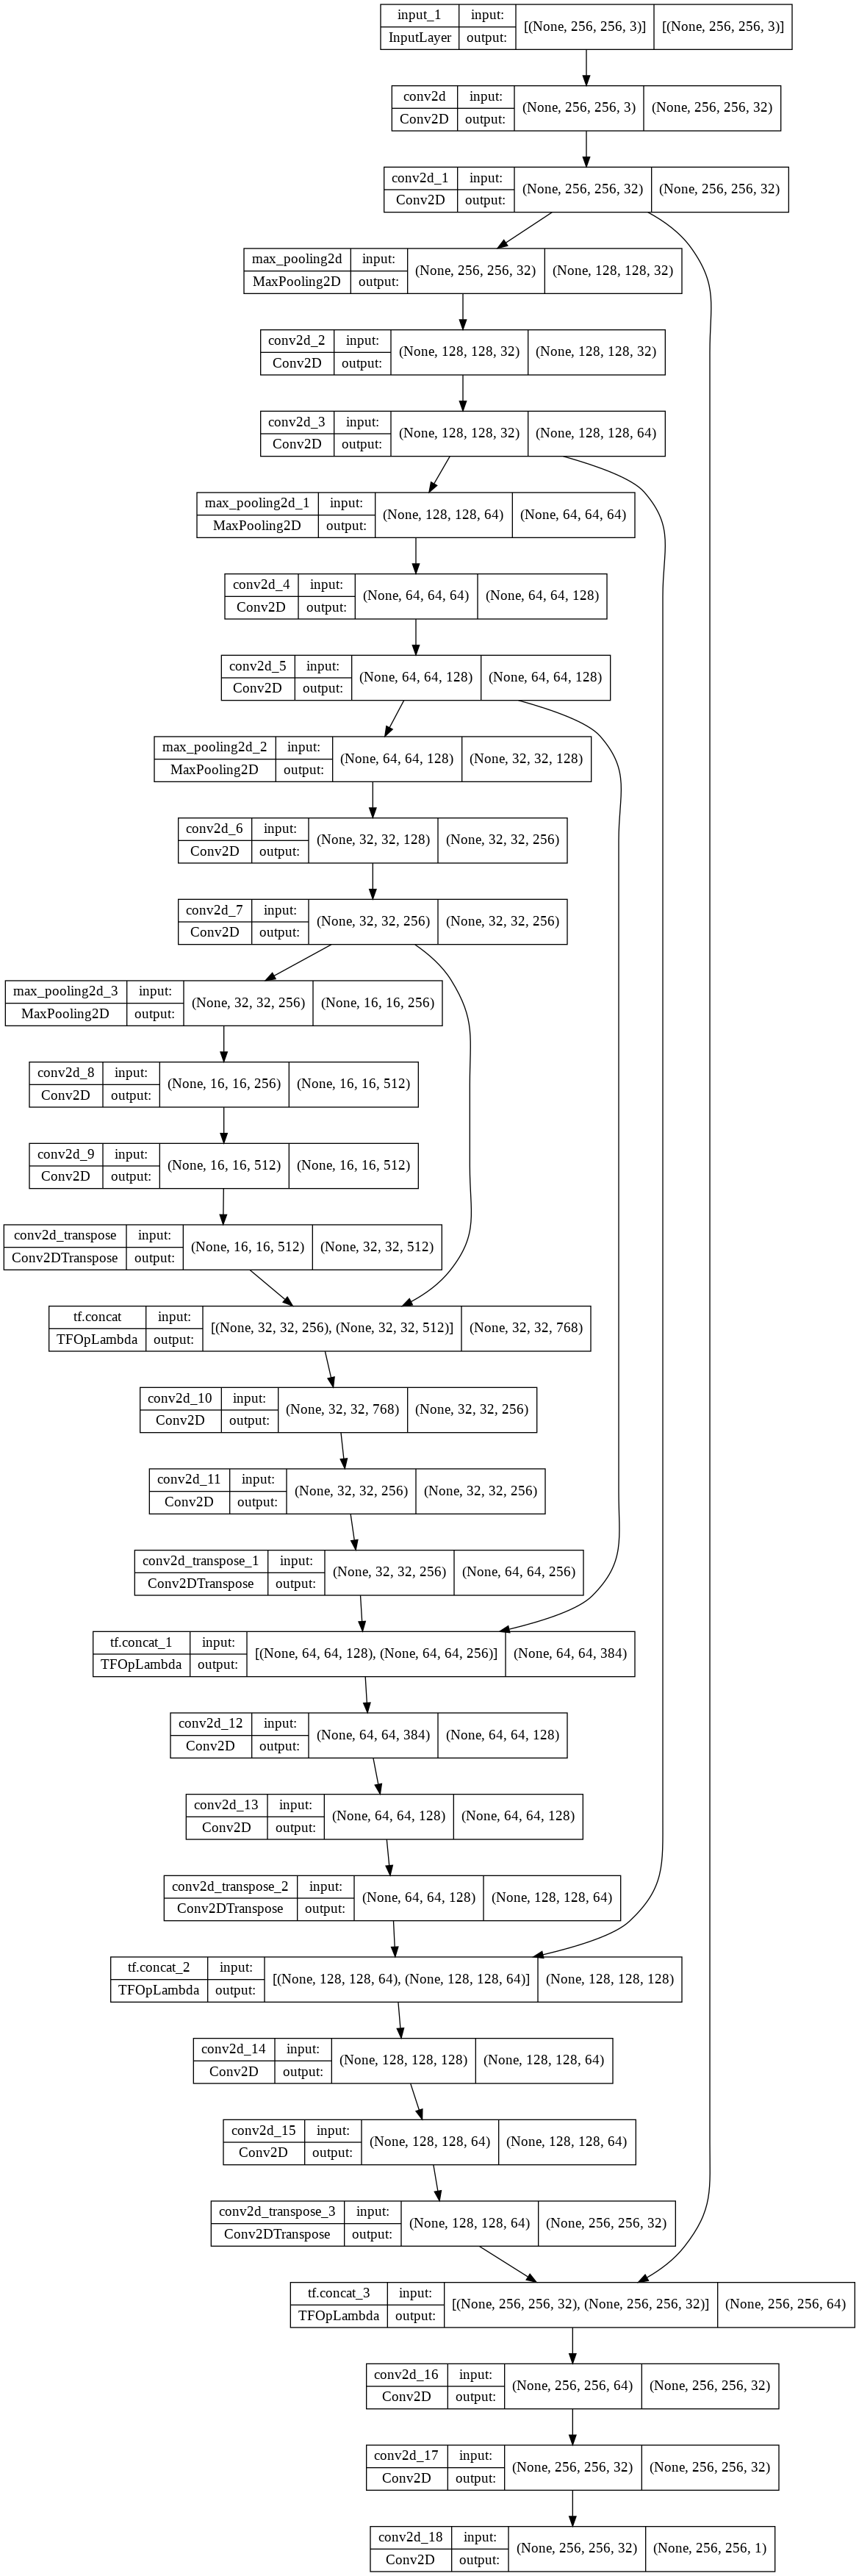

In [22]:
# Визуализируем граф
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

In [23]:
# Необходимо дополнительное суммирование или усреднение по пространственным измерениям карты признаков.
# Данную задачу выполняет функция BinaryCrossentropy().
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [24]:
# checkpoint_dir = './checkpoints'

# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                 filepath=checkpoint_prefix,
#                                 save_freq=1,
#                                 save_weights_only=True)

# EXP_NAME = 'transfer'

# checkpoint_callback = tf.keras.callbacks.TensorBoard(
#     log_dir='logs/'+EXP_NAME, 
#     write_graph=False, update_freq=100, profile_batch=0)

In [25]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
# inp_size = 256

hist = model.fit(train_ds,
                 batch_size=BATCH_SIZE, 
                 validation_data=val_ds,
                 epochs=NUM_EPOCHS)
                #  callbacks=[checkpoint_callback])

Epoch 1/10
437/437 [==============================] - 152s 309ms/step - loss: 0.4963 - accuracy: 0.7839 - val_loss: 0.5171 - val_accuracy: 0.7591
Epoch 2/10
437/437 [==============================] - 136s 311ms/step - loss: 0.4907 - accuracy: 0.7812 - val_loss: 0.5027 - val_accuracy: 0.7629
Epoch 3/10
437/437 [==============================] - 135s 309ms/step - loss: 0.4657 - accuracy: 0.7910 - val_loss: 0.4985 - val_accuracy: 0.7589
Epoch 4/10
437/437 [==============================] - 134s 307ms/step - loss: 0.4558 - accuracy: 0.7939 - val_loss: 0.4808 - val_accuracy: 0.7673
Epoch 5/10
437/437 [==============================] - 135s 309ms/step - loss: 0.4462 - accuracy: 0.7954 - val_loss: 0.5051 - val_accuracy: 0.7673
Epoch 6/10
437/437 [==============================] - 134s 307ms/step - loss: 0.4327 - accuracy: 0.7986 - val_loss: 0.4621 - val_accuracy: 0.7731
Epoch 7/10
437/437 [==============================] - 134s 307ms/step - loss: 0.4207 - accuracy: 0.8047 - val_loss: 0.4481 -

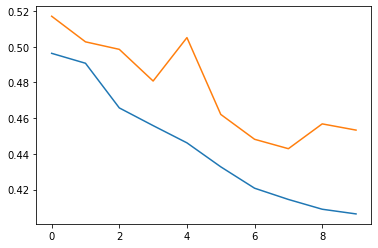

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Оценка качества модели

In [28]:
%%time

model.evaluate(val_ds)

12/12 [==============================] - 2s 185ms/step - loss: 0.4533 - accuracy: 0.7761
CPU times: user 2.66 s, sys: 111 ms, total: 2.77 s
Wall time: 2.71 s


[0.4532904624938965, 0.7760539054870605]

In [29]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None))>

## Проверка модели

In [30]:
# # Вариант 1

# for sample in val_ds:
#     out = model.predict(sample[None, ...])
#     seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
#     seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
#     plt.imshow(sample*0.5 + seg_map_clr*0.5)
#     plt.show()

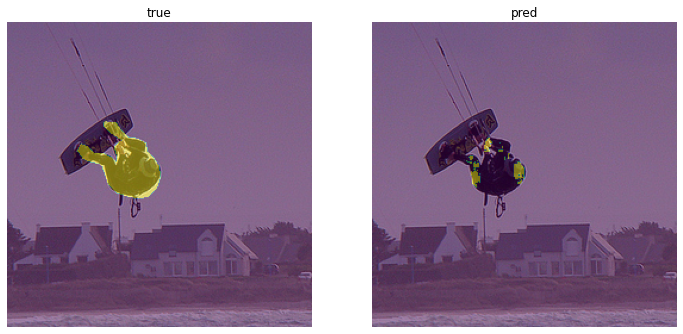

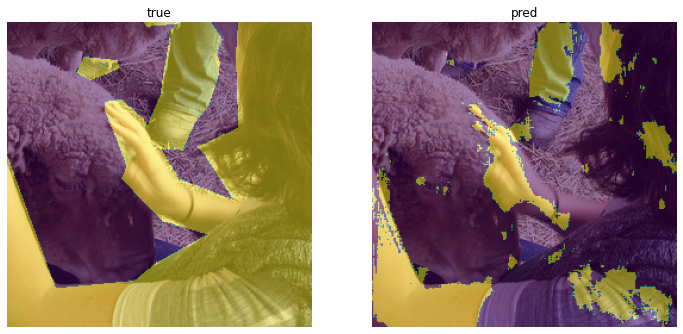

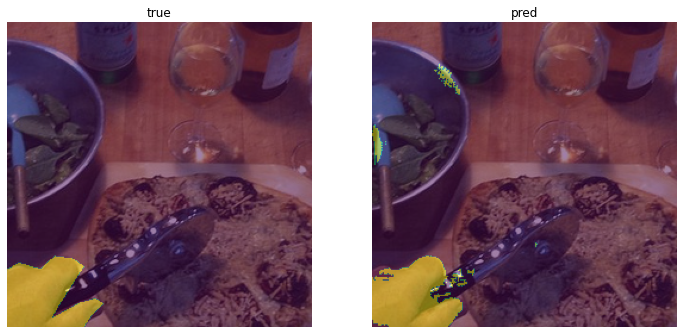

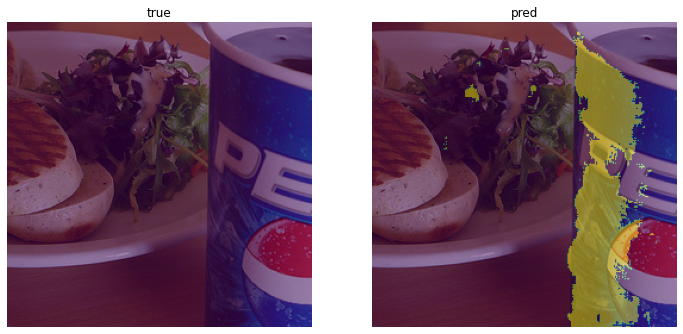

In [31]:
# Вариант 2

PERCEPTION = 0.5

train_x, train_y = next(iter(val_ds))

pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

In [32]:
# Вариант 3

img, mask = next(iter(val_ds.take(1)))

In [33]:
mask.shape

TensorShape([8, 256, 256, 1])

In [34]:
img.shape

TensorShape([8, 256, 256, 3])

In [35]:
mask_pred = model.predict(img)

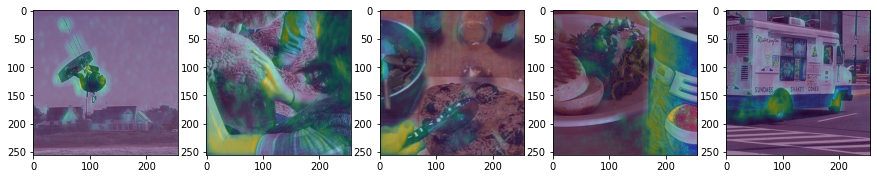

In [36]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask_pred[..., 0][i], alpha=0.5)
plt.show()

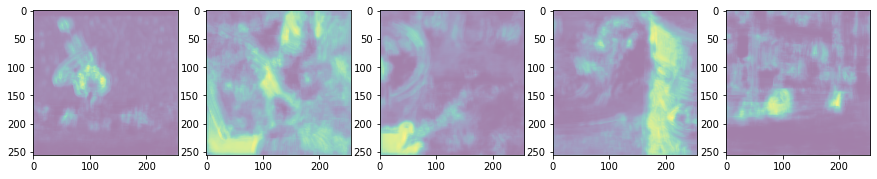

In [37]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    # ax.imshow(img[i])
    ax.imshow(mask_pred[..., 0][i], alpha=0.5)
plt.show()

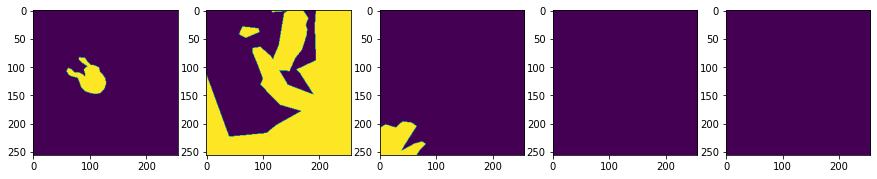

In [38]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    # ax.imshow(img[i])
    ax.imshow(mask[...,0][i])
plt.show()

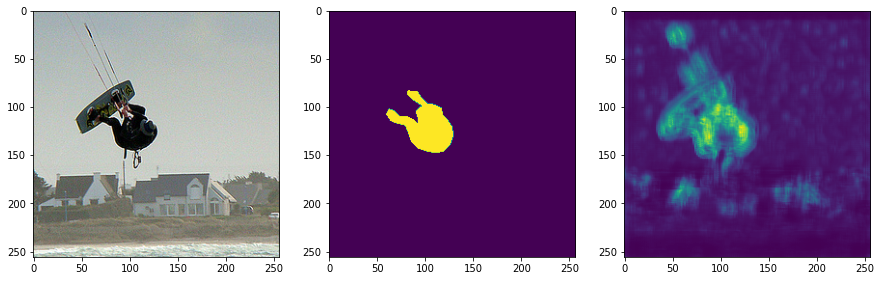

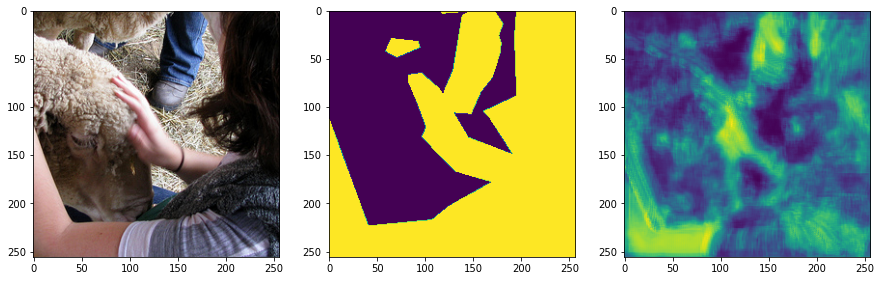

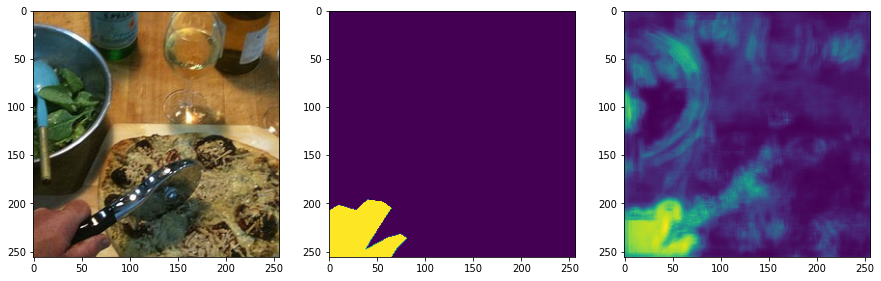

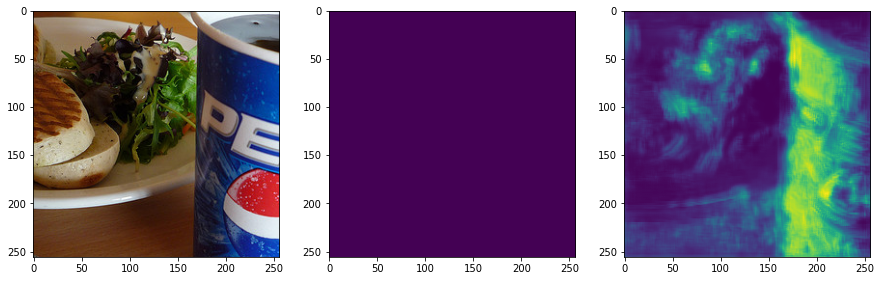

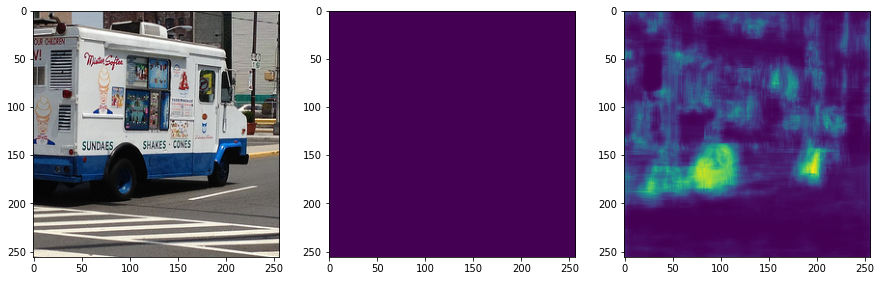

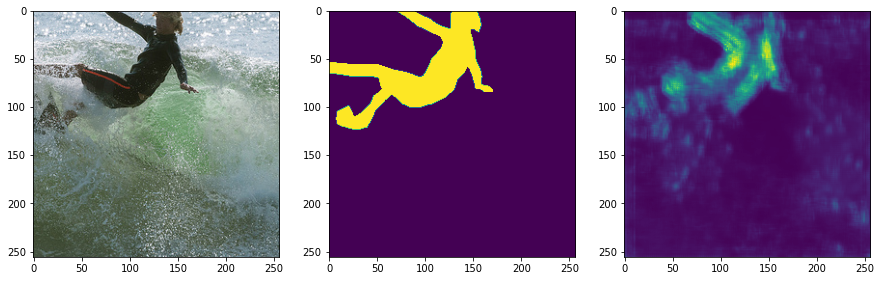

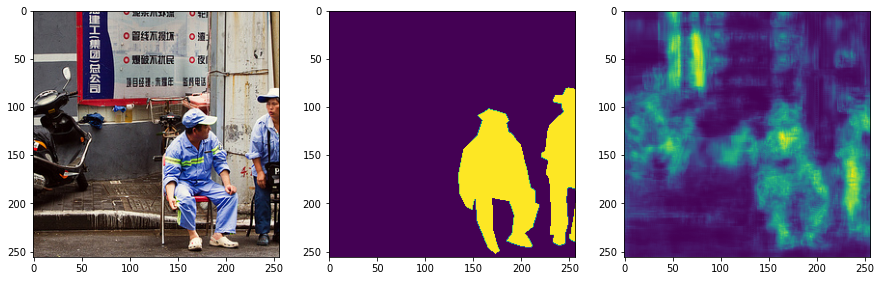

In [39]:
for i in range(7):
    fig, ax  = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(img[i])
    ax[1].imshow(mask[...,0][i])
    ax[2].imshow(mask_pred[..., 0][i])
    plt.show()